**Main imports**

In [3]:
import os
import requests
from tqdm import tqdm
import zipfile
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Imports complete.')

Imports complete.


**Download dataset**

In [4]:
# URL of the file
url = 'https://data.ncl.ac.uk/ndownloader/articles/24574354/versions/1'

# make directory if it doesn't exist
directory = 'classification-data'
if not os.path.exists(directory):
    os.makedirs(directory)

# where to save the downloaded file
file_path = os.path.join(directory, 'downloaded_file.zip')

# send a GET request to the URL with stream=True for chunked download
response = requests.get(url, stream=True)

# check if the request was successful
if response.status_code == 200:
    # total size in bytes from the header
    total_size = int(response.headers.get('content-length', 0))

    # progress bar
    with open(file_path, 'wb') as file, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
    ) as progress_bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
                progress_bar.update(len(chunk))

    print("File downloaded successfully!")

    # unzipping
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(directory)
        print(f"Files unzipped successfully in the '{directory}' directory!")

    # remove the zip file after extraction
    os.remove(file_path)
    print("Zip file removed after extraction.")

else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Downloading: 100%|██████████| 629M/629M [00:12<00:00, 51.3MB/s]    


File downloaded successfully!
Files unzipped successfully in the 'classification-data' directory!
Zip file removed after extraction.


**Import dataset**

In [5]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# directory where the data is stored
data_dir = 'classification-data'

# the .npy files
train_x_path = os.path.join(data_dir, 'train_x.npy')
train_y_path = os.path.join(data_dir, 'train_y.npy')
valid_x_path = os.path.join(data_dir, 'valid_x.npy')
valid_y_path = os.path.join(data_dir, 'valid_y.npy')
test_x_path = os.path.join(data_dir, 'test_x.npy')
test_y_path = os.path.join(data_dir, 'test_y.npy')

# load the data
print("Loading data...")
train_x = np.load(train_x_path)
train_y = np.load(train_y_path)
valid_x = np.load(valid_x_path)
valid_y = np.load(valid_y_path)
test_x = np.load(test_x_path)
test_y = np.load(test_y_path)
print("Data loaded successfully.")

# convert NumPy arrays to PyTorch tensors
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()
valid_x = torch.from_numpy(valid_x).float()
valid_y = torch.from_numpy(valid_y).long()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

# create TensorDataset instances
train_dataset = TensorDataset(train_x, train_y)
valid_dataset = TensorDataset(valid_x, valid_y)
test_dataset = TensorDataset(test_x, test_y)

# batch size
batch_size = 64

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Helper function to cycle through the data indefinitely
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# iterators for training, validation, and test loaders
train_iterator = iter(cycle(train_loader))
valid_iterator = iter(cycle(valid_loader))
test_iterator = iter(cycle(test_loader))

# class names
class_names = [str(i) for i in range(20)]

# dataset sizes
print(f'> Size of training dataset: {len(train_dataset)}')
print(f'> Size of validation dataset: {len(valid_dataset)}')
print(f'> Size of test dataset: {len(test_dataset)}')


Loading data...
Data loaded successfully.
> Size of training dataset: 45000
> Size of validation dataset: 15000
> Size of test dataset: 10000


**View some of the test dataset**

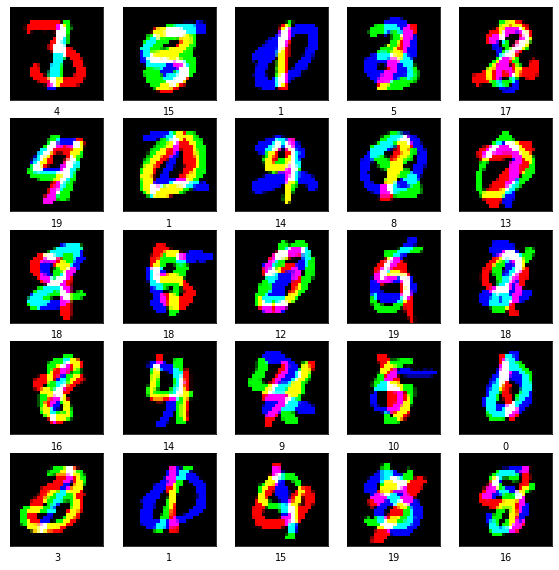

In [6]:
plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

**Define a simple model** - demo

In [7]:
# this is not a very good baseline classifier
class Classifier(nn.Module):
    def __init__(self, params):
        super(Classifier, self).__init__()

        self.layer1 = nn.Linear(28*28*params['n_channels'], params['n_hidden'])
        self.layer2 = nn.Linear(params['n_hidden'], params['n_classes'])

    def forward(self, x):
        x = self.layer1(x.view(x.size(0), -1))
        x = torch.relu(x)
        x = self.layer2(x)
        return x.view(x.size(0), -1)

# hyperparameters
params = {
    'n_channels': 3,  # number of channels
    'n_hidden':   30, # change to increase parameters
    'n_classes':  20  # number of classes
}

N = Classifier(params).to(device)

# print the number of parameters - this should be included in your report
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(N.parameters())) > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
plot_data = []
steps = 0

> Number of parameters 71210


**Main training and testing loop**

steps: 10000.00, train loss: 2.066, train acc: 0.273±0.054, test acc: 0.231±0.057


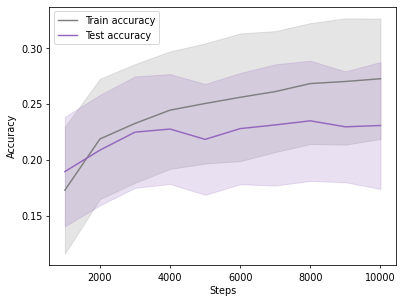

In [8]:
# keep within our optimisation step budget
while (steps < 10000):

    # arrays for metrics
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # iterate through some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()
        steps += 1

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # iterate over the entire test dataset
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)
        p = N(x)
        loss = torch.nn.functional.cross_entropy(p, t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # print your loss and accuracy data - include this in the final report
    print('steps: {:.2f}, train loss: {:.3f}, train acc: {:.3f}±{:.3f}, test acc: {:.3f}±{:.3f}'.format(
        steps, train_loss_arr.mean(),train_acc_arr.mean(),train_acc_arr.std(),test_acc_arr.mean(),test_acc_arr.std()))

    # plot your accuracy graph - add a graph like this in your final report
    plot_data.append([steps, np.array(train_acc_arr).mean(), np.array(train_acc_arr).std(), np.array(test_acc_arr).mean(), np.array(test_acc_arr).std()])
    reward_list = []
    plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
    plt.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Test accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data], alpha=0.2, color='tab:purple')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")
    plt.show()
    disp.clear_output(wait=True)

**Inference on dataset**

This is useful for analysis but is entirely optional

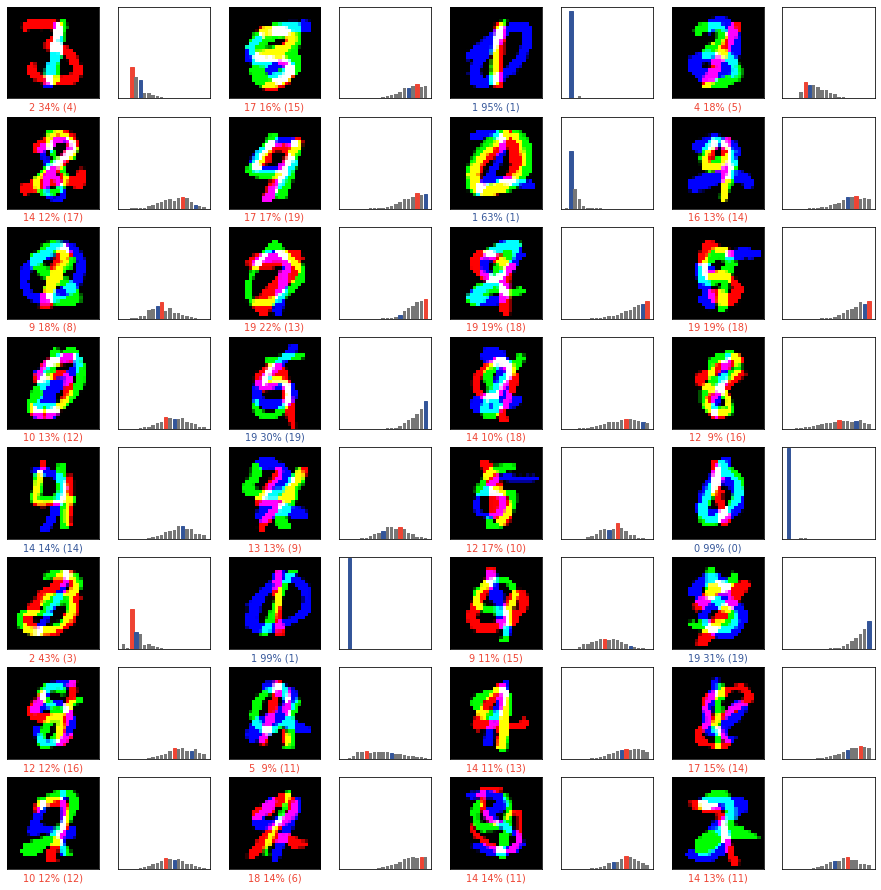

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    img = np.clip(img, 0, 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(20), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images), dim=1).data.cpu().numpy()
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())